In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
import pandas as pd
from IPython.display import Image
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.analytic import UpperConfidenceBound
import warnings
import gymnasium as gym
import umap
import importlib

In [2]:
import env.make
import env.eval
import env.dataset
import utils.utils as utils
importlib.reload(env.make)
importlib.reload(env.eval)
importlib.reload(env.dataset)
importlib.reload(utils);

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
DEVICE = utils.find_device(force_cpu=False)

Using device cuda


In [5]:
FIG_FOLDER, BACKUP_FOLDER = utils.make_folders()

Figures folder: ./figures
Backup folder: ./backup


# Create env and fix horizon

In [6]:
ENV = env.make.mujoco_cartpole()
TIME_HORIZON = 20

# Creating a dataset

In [7]:
train_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=1234)
test_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=12345)

Sampling trajectories and evaluating them...
n=2000; avg = 0.303 +/- 0.166; range  = 0.150, 1.000
Sampling trajectories and evaluating them...
n=2000; avg = 0.296 +/- 0.160; range  = 0.150, 1.000


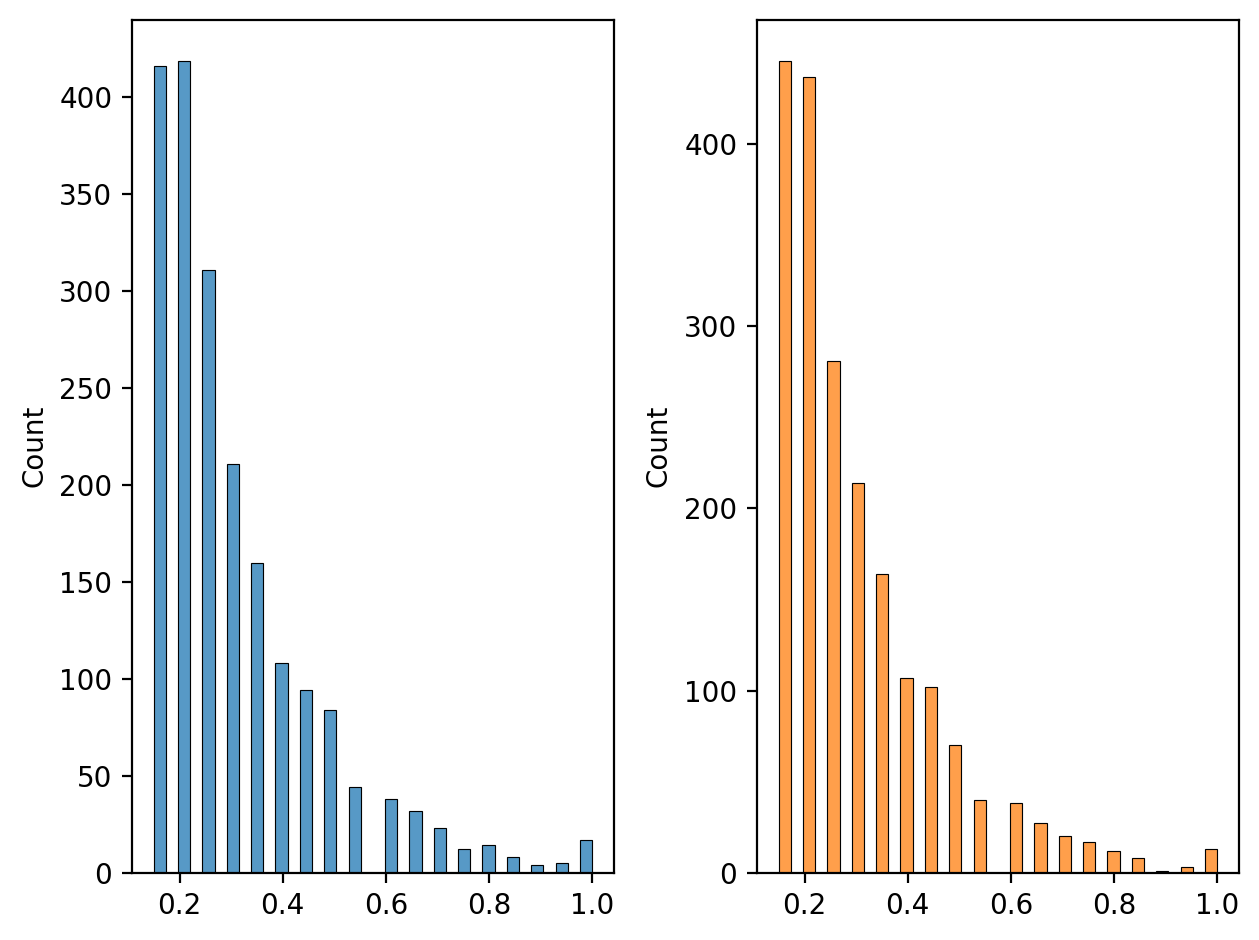

In [8]:
fig, axes = plt.subplots(ncols=2)
sns.histplot(ax=axes[0], x=train_dataset.y.cpu().numpy())
sns.histplot(ax=axes[1], x=test_dataset.y.cpu().numpy(), color="C1")
plt.tight_layout();

# AE

## Defining the AE model

In [11]:
class AE(nn.Module):

    def __init__(self, n_steps, z_dim, out_encoder=500):
        super().__init__()

        # Encoder 

        self.enc = nn.Sequential(
            nn.Linear(n_steps, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, z_dim))
        
        # Decoder 

        self.dec = nn.Sequential(
            nn.Linear(z_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Lineear(500, 500),
            nn.ReLU(),
            nn.Linear(500, n_steps))

    def encode(self, x):
        x = self.enc(x)
        return x

    def decode(self, z):
        x = torch.sigmoid(self.dec(z))
        return x

    def forward(self, x):
        x = self.encode(x)
        return self.decode(z)

In [12]:
dim_z = 2
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
ae = AE(z_dim=size_z, device=DEVICE).to(DEVICE)
for batch_idx, (x, y) in enumerate(train_loader):
    z = ae.encode(x)
    x_rec = ae.decode(z)
    break

TypeError: __init__() got an unexpected keyword argument 'z_dim'

In [216]:
class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred = nn.Sequential(
            nn.Linear(size_z, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 1)
        )
        
    def forward(self, x):
        x = self.pred(x)
        return x.squeeze()

## Training AE

In [217]:
def eval_reconstruction(model, data_loader):
    delta = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(data_loader):
            recon_x = model(x)
            delta += torch.abs(x - recon_x).sum()

    n = len(data_loader.dataset)
    delta /= (n*model.time_horizon)
    print(f"Avg reconstruction error: {delta.item():.4f}")    

### Random level for reconstruction

In [218]:
x = train_dataset.x
recon_x = torch.rand_like(x)
delta = torch.abs(x - recon_x)
print(f"Avg reconstruction error: {delta.mean().item():.4f} +/- {delta.std().item():.4f}")

Avg reconstruction error: 0.3325 +/- 0.2359


### Initial level of reconstruction error

In [220]:
seed = 1234
torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, z_dim=size_z, device=DEVICE).to(DEVICE)

train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2854
Avg reconstruction error: 0.2834


### Training loop

In [ ]:
seed = 1234
size_z = 2
lr = 0.01
batch_size = len(train_dataset.y)
n_epoch = 5000

torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, z_dim=size_z, device=DEVICE).to(DEVICE)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

optimizer = optim.Adam(list(ae.parameters()), lr=lr) # + list(reg.parameters()), lr=lr)

hist_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        epoch_loss = 0 
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer.zero_grad()
            recon_x = ae(x)
            loss = nn.L1Loss(reduction="mean")(target=x, input=recon_x)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        hist_loss.append(epoch_loss/len(train_loader))

        pbar.update()
        pbar.set_postfix(loss=f"{hist_loss[-1]:.5f}")

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2854
Avg reconstruction error: 0.2834


  0%|          | 0/5000 [00:00<?, ?it/s]

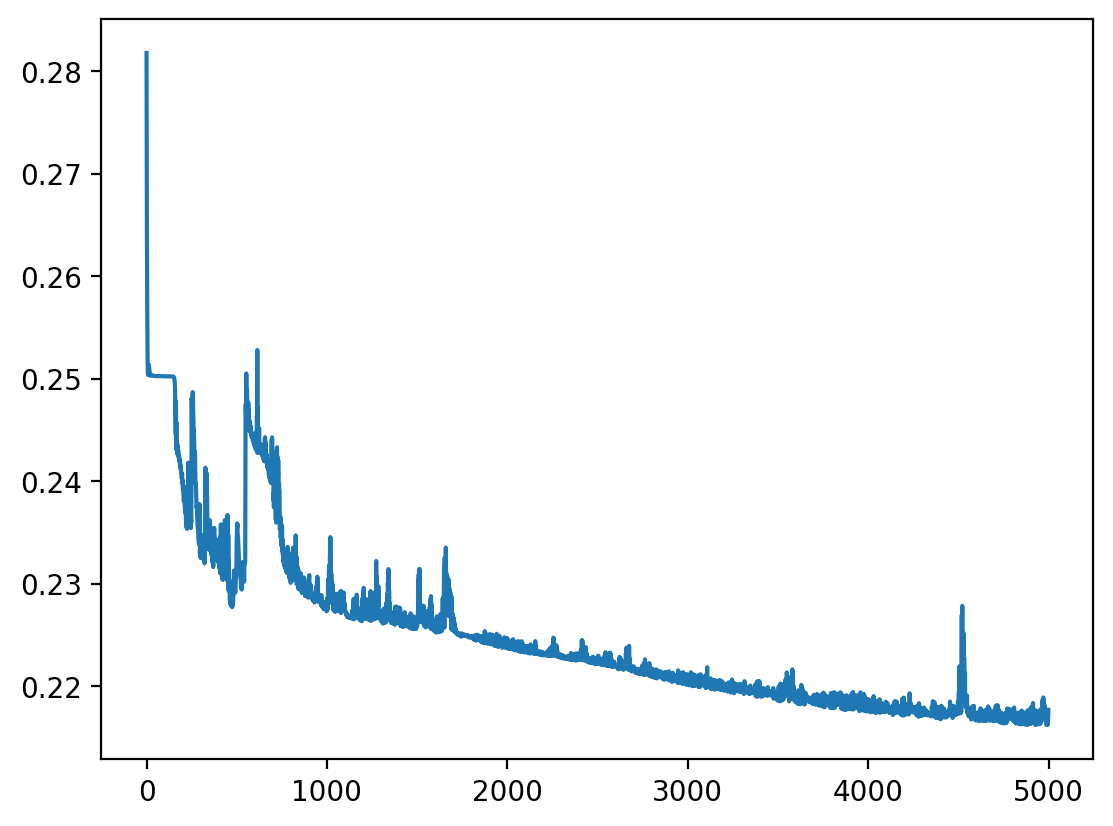

In [211]:
plt.plot(hist_loss)

In [212]:
eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2167
Avg reconstruction error: 0.2201


## Visualize structuration of the latent space

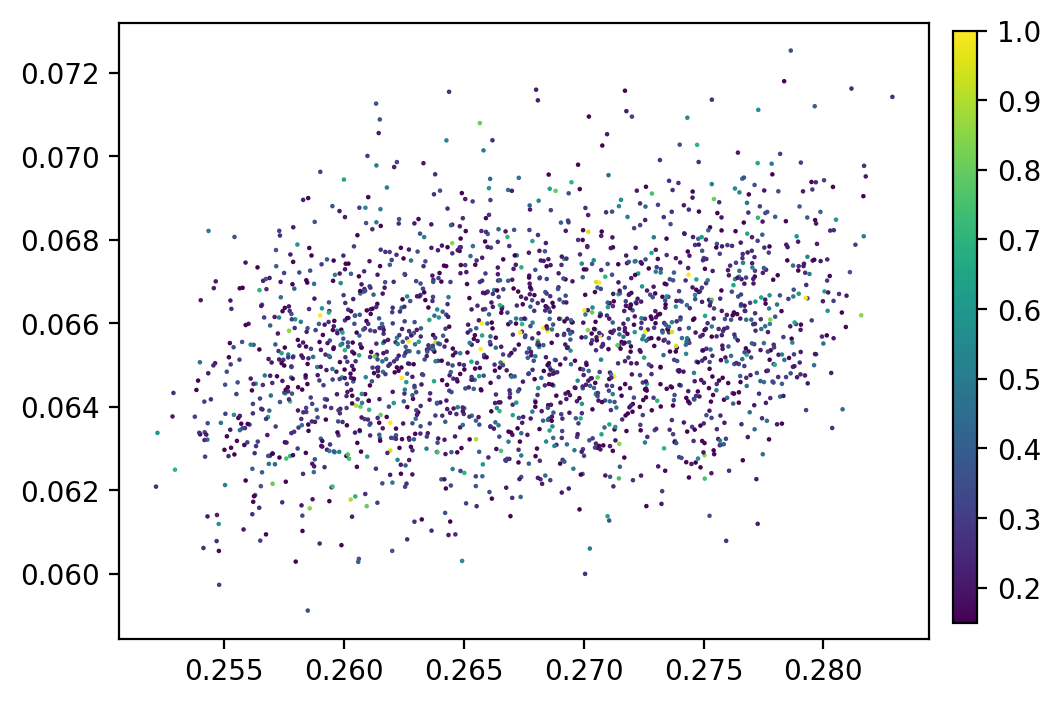

In [213]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    mu, logvar = vae.encode(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    mu, logvar = vae.encode(x)
    z = mu
    x_rec = vae.decode(z)
    y_rec = eval_trajectories(x_rec)

all_y = torch.cat([y, y_rec])
vmin, vmax = all_y.min(), all_y.max()

z = z.cpu().numpy()
y_rec = y_rec.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y_rec,
    cmap="viridis",
    vmin=vmin, vmax=vmax,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

x_lim = min(z[:, 0]), max(z[:, 0]) 
y_lim = min(z[:, 1]), max(z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

# im = plt.contourf(gx, gy, gz, cmap='viridis')
fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) # vmin=0.0, vmax=1.0)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    dataset_z = mu.cpu().numpy()
    dataset_y = y.cpu().numpy()

x_lim = min(dataset_z[:, 0]), max(dataset_z[:, 0]) 
y_lim = min(dataset_z[:, 1]), max(dataset_z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    print(x.shape)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
ax.scatter(
    dataset_z[:, 0], dataset_z[:, 1], 
    c=dataset_y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)


fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_x, mu, logvar = vae(x)
    dataset_z = mu.cpu().numpy()
    x_prime = vae.decode(mu)
    x_prime = x_prime.cpu().numpy() 
    y = np.zeros(len(x_prime))
    for i in range(len(x_prime)):
        y[i] = eval_trajectory(trajectory=x_prime[i]) / TIME_HORIZON
    
    dataset_y = y

x_lim = min(dataset_z[:, 0]), max(dataset_z[:, 0]) 
y_lim = min(dataset_z[:, 1]), max(dataset_z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
ax.scatter(
    dataset_z[:, 0], dataset_z[:, 1], 
    c=dataset_y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)


fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

## Same thing but using the regressor from the latent

In [ ]:
vae.eval()
rx, ry = np.linspace(*x_lim, 20), np.linspace(*y_lim, 20)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()

    y = reg(z)
    
    # x = x.cpu().numpy()
    y = y.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz)  #, vmin=0.0, vmax=1.0);

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz) #, #vmin=0.0, vmax=1.0)

vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=3.0)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

# Using GP after VAE trained

In [ ]:
n_sample_start = 40

# Create a small dataset from the dataset the VAE has been trained with
best = torch.topk(train_dataset.y, k=n_sample_start).indices
train_x = train_dataset.x[best]
train_y = train_dataset.y[best]

# best_reward = train_y.max()
# train_y /= best_reward


with torch.no_grad():
    vae.eval()
    train_z, _ = vae.encode(train_dataset.x[best])

train_x = train_x.double()
train_y = train_y.double()
train_z = train_z.double()

fig, ax = plt.subplots()
ax.scatter(
    x=train_z[:, 0].numpy(), 
    y=train_z[:, 1].numpy(), 
    c=train_y.numpy(),  
    cmap="viridis");

In [ ]:


x_lim = -4, 4 
y_lim = -4, 4

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
plt.colorbar(im);

In [ ]:
bounds = torch.tensor([[-4.0] * size_z, [4.0] * size_z]).to(device)

n_sample_start = 500

# Create a small dataset from the dataset the VAE has been trained with
train_z = unnormalize(torch.rand(n_sample_start, size_z, device=device, dtype=dtype), bounds=bounds)


# best_reward = train_y.max()
# train_y /= best_reward


with torch.no_grad():
    vae.eval()
    train_x = vae.decode(train_z)
    train_y = torch.tensor([eval_trajectory(traj.cpu().numpy()) for traj in train_x]) / TIME_HORIZON

train_x = train_x.double()
train_y = train_y.double()
train_z = train_z.double()

fig, ax = plt.subplots()
im = ax.scatter(
    x=train_z[:, 0].numpy(), 
    y=train_z[:, 1].numpy(), 
    c=train_y.numpy(),  
    cmap="viridis")
plt.colorbar(im);

In [ ]:
torch.manual_seed(1234)

dtype=torch.float

acq_opt__batch_size = 20
acq_opt__num_restarts = 10
acq_opt__raw_samples = 256

qmc_sampler__sample_shape = 2048
qmc_sampler__seed = 123

n_batch = 20

best_observed = []
cand_observed = []
val_observed = []

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
with tqdm(total=n_batch) as pbar:
    for iteration in range(n_batch):

        # bound = torch.max(torch.tensor([-train_z.min(), train_z.max()]))

        # fit the GP model
        # normalize(train_h, bounds=bounds), 
        # standardize(train_obj) 
        normalized_train_z = normalize(train_z, bounds=bounds)
        standardized_train_y = standardize(train_y.unsqueeze(dim=1))
        # print(normalized_train_z)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = SingleTaskGP(train_X=normalized_train_z, train_Y=standardized_train_y)
        # if state_dict is not None:
        #     model.load_state_dict(state_dict)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        mll.to(device)
        fit_gpytorch_mll(mll)

        # define the qNEI acquisition module using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(
            sample_shape=qmc_sampler__sample_shape,
            seed=qmc_sampler__seed)
        acq_f = qExpectedImprovement(
            model=model, 
            sampler=qmc_sampler, 
            best_f=train_y.max())
        # acq_f = UpperConfidenceBound(model=model, beta=0.2)
        # optimize and get new observation
        # optimize
        candidates, _ = optimize_acqf(
            acq_function=acq_f,
            bounds=bounds,
            q=acq_opt__batch_size,
            num_restarts=acq_opt__num_restarts,
            raw_samples=acq_opt__raw_samples,
        )

        # observe new values 
        with torch.no_grad():
            new_z = unnormalize(candidates.detach(), bounds=bounds)
            new_x = vae.decode(new_z)
            new_y = torch.tensor([eval_trajectory(traj.cpu().numpy()) for traj in new_x]) / TIME_HORIZON

        # update training points
        train_z = torch.cat((train_z, new_z))
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))

        # update progress
        best_value = train_y.max().item()
        best_observed.append(best_value)
        for z, y in zip(new_z, new_y):
            cand_observed.append(z.numpy().tolist())
            val_observed.append(y.item())

        # state_dict = model.state_dict()
        
        pbar.update()
        pbar.set_postfix({"best": f"{best_value:.2f}"})

In [ ]:
fig, ax = plt.subplots()
ax.plot(best_observed);

In [ ]:
cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed).squeeze()

s = np.repeat(np.linspace(1, 10, n_batch)**2, acq_opt__batch_size)
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

fig, ax = plt.subplots()
im = ax.scatter(x=x, y=y, c=c, s=s, cmap="viridis")
plt.colorbar(im);

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

x_lim = min(z[:, 0]), max(z[:, 0]) 
y_lim = min(z[:, 1]), max(z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    print(x.shape)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

# im = plt.contourf(gx, gy, gz, cmap='viridis')
fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz)  #, vmin=0.0, vmax=1.0)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed).squeeze()

s = np.repeat(np.linspace(1, 10, n_batch)**2, acq_opt__batch_size)
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

ax.scatter(x=x, y=y, c=c, s=s, cmap="viridis");

In [ ]:
s = np.linspace(10, 50, len(val_observed))
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

In [ ]:
print(c.shape, s.shape, x.shape, y.shape)

In [ ]:
np.repeat([1, 2, 3], 3)

In [ ]:
x_lim = -40, 40
y_lim = -40, 40

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
plt.colorbar(im);